In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
import re
import string
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
# Load data
train_path = "../data/raw/BBC News Train.csv"
test_path = "../data/raw/BBC News Test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
# View data
display(train_df.head())
display(train_df["Category"].value_counts())

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [4]:
# CLEANS TEXT AND RETURNS A STRING: LOWERCASING, REMOVING DIGITS AND PUNCTUATION, TOKENIZING, PARTS OF SPEECH TAGGING, LEMMATIZING

lemmatizer = WordNetLemmatizer()

# Map nltk part of speech tags to wordnet part of speech tags
def get_wordnet_pos(treebank_tag):
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)

custom_stopwords = set([
    "said", "mr", "year", "new", "people", "s", "m", "t",
    "one", "two", "first", "last", "also", "would", "was", "has"
])
combined_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
        if word.isalpha() and len(word) > 1 and word not in combined_stopwords
    ]

    return " ".join(lemmatized_tokens)


In [5]:
# CREATES TF-IDF FEATURES WITH UNIGRAMS AND BIGRAMS, TRAINS NMF TO EXTRACT TOPICS, AND ASSIGNS TOPICS TO LABELS USING MAJORITY VOTE

def create_tfidf_matrix(train_texts, test_texts, max_features):
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
    )
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer

def train_nmf(X_train, n_topics, random_state=22):
    nmf = NMF(n_components=n_topics, random_state=random_state)
    W_train = nmf.fit_transform(X_train)
    return nmf, W_train

def assign_topics_to_labels(W, true_labels):
    topic_assignments = np.argmax(W, axis=1)
    topic_to_label = {}

    for topic in np.unique(topic_assignments):
        labels = true_labels[topic_assignments == topic]
        if len(labels) > 0:
            topic_to_label[topic] = labels.mode().iloc[0]

    predicted_labels = [topic_to_label[t] for t in topic_assignments]
    return predicted_labels, topic_to_label

In [6]:
# Clean and preprocess
train_df["CleanText"] = train_df["Text"].apply(clean_text)
test_df["CleanText"] = test_df["Text"].apply(clean_text)
train_df["WordCount"] = train_df["CleanText"].apply(lambda x: len(x.split()))

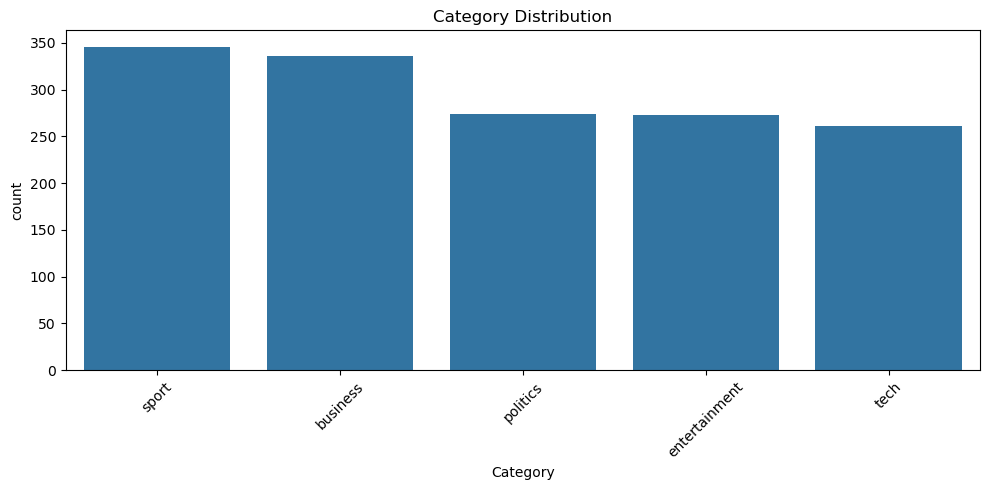

In [7]:
# Visualization - category distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x="Category", order=train_df["Category"].value_counts().index)
plt.title("Category Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

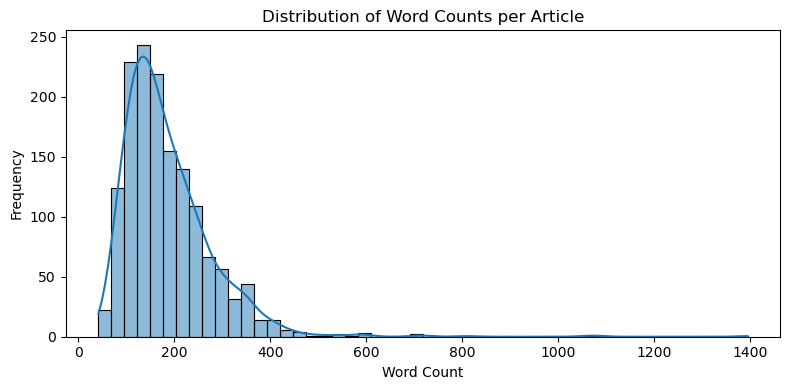

In [8]:
# Visualization - word count distribution
plt.figure(figsize=(8, 4))
sns.histplot(train_df["WordCount"], bins=50, kde=True)
plt.title("Distribution of Word Counts per Article")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

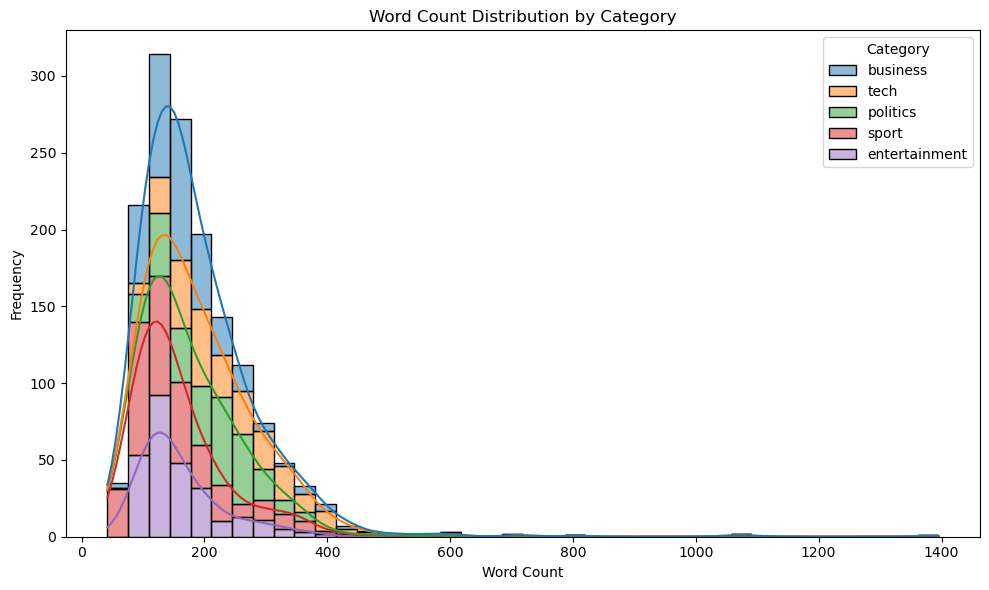

In [9]:
# Visualization - word count distribution by category (1)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x="WordCount", hue="Category", bins=40, kde=True, multiple="stack")
plt.title("Word Count Distribution by Category")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

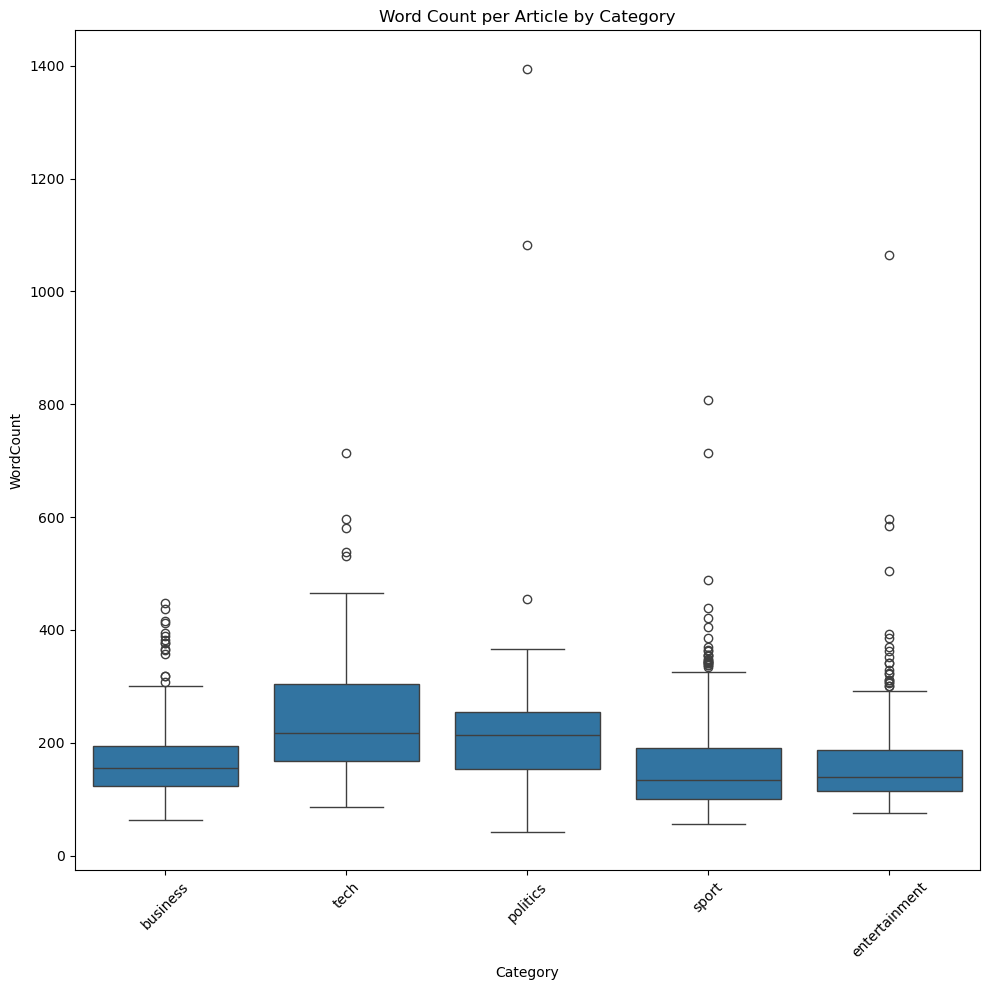

In [10]:
# Visualization - word count distribution by category (2)
plt.figure(figsize=(10, 10))
sns.boxplot(data=train_df, x="Category", y="WordCount")
plt.title("Word Count per Article by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

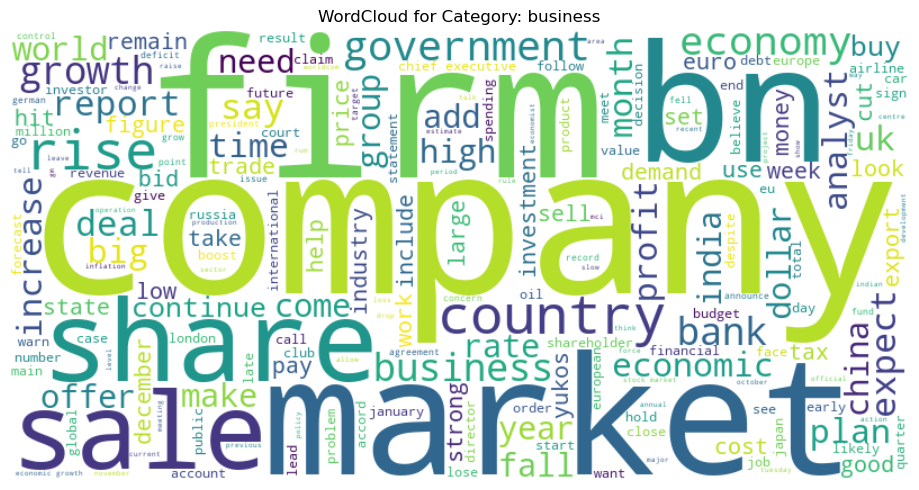

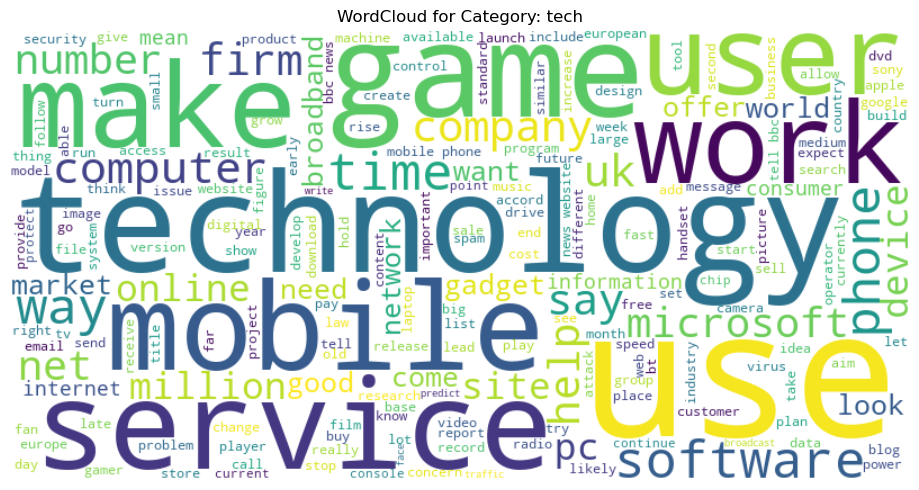

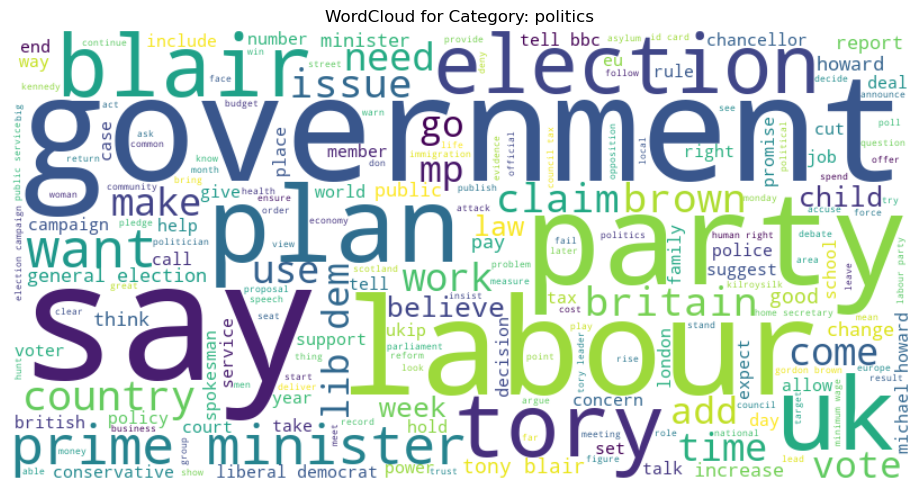

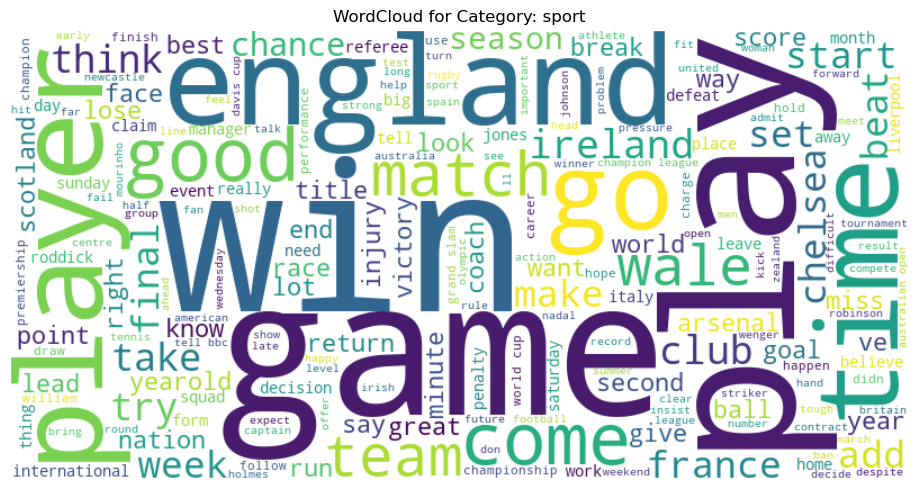

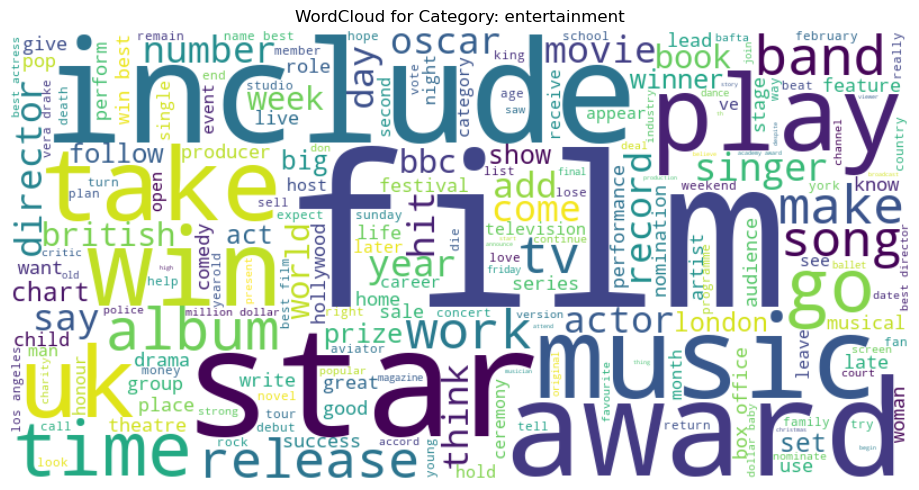

In [11]:
# Word clouds - 1 per category
for cat in train_df["Category"].unique():
    text = " ".join(train_df[train_df["Category"] == cat]["CleanText"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for Category: {cat}")
    plt.tight_layout()
    plt.show()

In [12]:
# EXTRACTS AND DISPLAYS FREQUENT WORDS FOR EACH CATEGORY

def get_top_words_by_category(df, text_column="CleanText", category_column="Category", top_n=10):
    categories = df[category_column].unique()
    top_words_by_cat = {}

    for cat in categories:
        all_text = " ".join(df[df[category_column] == cat][text_column])
        word_list = all_text.split()
        word_counts = Counter(word_list)
        top_words = word_counts.most_common(top_n)
        top_words_by_cat[cat] = top_words

    return top_words_by_cat

# Call the function
top_words_by_cat = get_top_words_by_category(train_df, top_n=10)

# Display as a readable table
top_words_df = pd.DataFrame({
    category: [f"{word} ({count})" for word, count in top_words]
    for category, top_words in top_words_by_cat.items()
})

top_words_df

,business,tech,politics,sport,entertainment
0,bn (393),use (606),labour (488),win (584),film (703)
1,company (392),game (430),government (469),game (483),best (404)
2,firm (375),mobile (418),party (449),play (395),award (341)
3,market (344),phone (394),election (448),england (327),star (318)
4,sale (276),technology (380),say (443),player (308),win (261)
5,rise (270),service (369),blair (390),world (266),music (255)
6,bank (257),user (300),minister (371),time (262),include (231)
7,growth (257),make (291),tory (325),match (229),actor (204)
8,share (251),net (269),plan (322),go (228),band (179)
9,economy (250),firm (265),brown (261),good (216),play (171)


In [13]:
# EXTRACTS AND DISPLAYS TOP BIGRAMS FOR ENTIRE CORPUS AND EACH CATEGORY RESPECTIVELY

# Get top bigrams for entire corpus
def get_top_bigrams(corpus, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000)
    X = vectorizer.fit_transform(corpus)
    bigram_freq = X.sum(axis=0).A1
    bigrams = vectorizer.get_feature_names_out()
    bigram_df = pd.DataFrame({"bigram": bigrams, "count": bigram_freq})
    bigram_df = bigram_df.sort_values(by="count", ascending=False).head(top_n)
    return bigram_df

# Get top bigrams per category
def get_top_bigrams_per_category(df, category_column="Category", text_column="CleanText", top_n=10):
    result = {}
    for cat in df[category_column].unique():
        cat_corpus = df[df[category_column] == cat][text_column]
        bigram_df = get_top_bigrams(cat_corpus, top_n=top_n)
        result[cat] = bigram_df
    return result


In [14]:
# Top bigrams for entire corpus
top_bigrams_overall = get_top_bigrams(train_df["CleanText"], top_n=20)
display(top_bigrams_overall)

# Top bigrams per category
top_bigrams_by_category = get_top_bigrams_per_category(train_df, top_n=10)
for cat, df in top_bigrams_by_category.items():
    print(f"\nTop bigrams for category: {cat}")
    display(df)


,bigram,count
4396,tell bbc,236
3422,prime minister,222
2867,mobile phone,145
1780,general election,132
4486,tony blair,130
651,chief executive,124
299,bbc news,116
2525,liberal democrat,110
4981,year ago,89
2775,michael howard,83



Top bigrams for category: business


,bigram,count
726,chief executive,84
1411,economic growth,53
4390,stock market,51
3258,oil price,41
4388,stock exchange,34
965,consumer spending,32
1285,deutsche boerse,32
4321,sri lanka,28
439,bn euro,27
4297,south korea,25



Top bigrams for category: tech


,bigram,count
2720,mobile phone,131
120,bbc news,60
4665,tell bbc,57
2817,news website,50
2581,mac mini,45
302,consumer electronics,41
189,camera phone,40
2195,hard drive,39
2783,music player,37
3528,search engine,36



Top bigrams for category: politics


,bigram,count
3394,prime minister,193
4778,tony blair,124
1854,general election,123
2623,liberal democrat,110
4689,tell bbc,89
2743,michael howard,83
2622,lib dems,77
2197,home secretary,69
1952,gordon brown,69
2621,lib dem,56



Top bigrams for category: sport


,bigram,count
1834,grand slam,66
4926,world cup,63
525,champion league,57
197,australian open,53
4292,tell bbc,52
922,davis cup,42
232,bbc sport,38
1157,drug test,32
4936,world number,31
3821,second half,30



Top bigrams for category: entertainment


,bigram,count
623,box office,64
4854,win best,59
515,best film,43
3000,name best,41
2689,los angeles,39
4704,vera drake,39
1356,dollar baby,37
2845,million dollar,37
496,best actress,36
510,best director,34


In [15]:
# TRAINS NMF MODELS WITH DIFFERENT NUMBERS OF TOPICS AND COMPUTES ACCURACY 

results_topics = []

for n_topics in [1, 5, 10, 15, 20]:
    X_train_tfidf, X_test_tfidf, _ = create_tfidf_matrix(
        train_df["CleanText"], test_df["CleanText"], max_features=5000
    )
    nmf_model, W_train = train_nmf(X_train_tfidf, n_topics=n_topics)
    train_preds, _ = assign_topics_to_labels(W_train, train_df["Category"])
    
    acc = accuracy_score(train_df["Category"], train_preds)
    results_topics.append({"n_topics": n_topics, "max_features": 5000, "accuracy": acc})

pd.DataFrame(results_topics)


,n_topics,max_features,accuracy
0,1,5000,0.232215
1,5,5000,0.934899
2,10,5000,0.922819
3,15,5000,0.937584
4,20,5000,0.910067


In [16]:
# TRAINS NMF MODELS WITH DIFFERENT VOCABULARY SIZES AND COMPUTES ACCURACY

results_features = []

for max_features in [500, 1000, 3000, 5000, 7000]:
    X_train_tfidf, X_test_tfidf, _ = create_tfidf_matrix(
        train_df["CleanText"], test_df["CleanText"], max_features=max_features
    )
    nmf_model, W_train = train_nmf(X_train_tfidf, n_topics=10)
    train_preds, _ = assign_topics_to_labels(W_train, train_df["Category"])
    
    acc = accuracy_score(train_df["Category"], train_preds)
    results_features.append({"n_topics": 10, "max_features": max_features, "accuracy": acc})

pd.DataFrame(results_features)


/opt/anaconda3/envs/dtsa_5510/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,n_topics,max_features,accuracy
0,10,500,0.893960
1,10,1000,0.920134
2,10,3000,0.879866
3,10,5000,0.922819
4,10,7000,0.882550


In [17]:
# PERFORMS GRID SEARCH OVER NMF TOPIC COUNTS AND FEATURE SIZES, TRAINS MODELS AND COMPUTES ACCURACY 

results_grid = []

for n_topics in [5, 10, 15]:
    for max_features in [1000, 3000, 5000]:
        X_train_tfidf, X_test_tfidf, _ = create_tfidf_matrix(
            train_df["CleanText"], test_df["CleanText"], max_features=max_features
        )
        nmf_model, W_train = train_nmf(X_train_tfidf, n_topics=n_topics)
        train_preds, _ = assign_topics_to_labels(W_train, train_df["Category"])

        acc = accuracy_score(train_df["Category"], train_preds)
        results_grid.append({"n_topics": n_topics, "max_features": max_features, "accuracy": acc})

pd.DataFrame(results_grid).sort_values(by="accuracy", ascending=False)


,n_topics,max_features,accuracy
8,15,5000,0.937584
2,5,5000,0.934899
5,10,5000,0.922819
7,15,3000,0.922819
3,10,1000,0.920134
0,5,1000,0.900671
1,5,3000,0.897987
6,15,1000,0.882550
4,10,3000,0.879866


In [18]:
# Train NMF model using best parameters identified from grid search over topic counts and feature sizes
n_topics = 15
max_features = 5000

X_train_tfidf, _, tfidf_vectorizer = create_tfidf_matrix(
    train_texts=train_df["CleanText"],
    test_texts=train_df["CleanText"],
    max_features=max_features
)

nmf_model, W_train = train_nmf(X_train_tfidf, n_topics=n_topics)
train_preds, topic_to_label_map = assign_topics_to_labels(W_train, train_df["Category"])


# Accuracy
accuracy = accuracy_score(train_df["Category"], train_preds)
print(f"Training accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(train_df["Category"], train_preds, labels=train_df["Category"].unique())
print("Confusion matrix:\n", cm)

# Display top words for each topic identified by NMF model
# Validates the quality of the unsupervised clustering
feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx}: {top_words}")

# Check model produces balanced distribution by coutning number of docs assigned to each topic
topic_assignments = np.argmax(W_train, axis=1)
unique, counts = np.unique(topic_assignments, return_counts=True)

print("\nTopic Assignment Distribution:")
for topic, count in zip(unique, counts):
    print(f"  Topic {topic}: {count} documents")

Training accuracy: 0.9376
Confusion matrix:
 [[307   8  18   2   1]
 [  4 238  10   1   8]
 [  3   5 259   7   0]
 [  2   2   0 339   3]
 [  3   3  11   2 254]]
Topic 0: ['chelsea', 'club', 'arsenal', 'league', 'liverpool', 'game', 'mourinho', 'ferguson', 'goal', 'player']
Topic 1: ['tax', 'party', 'tory', 'election', 'labour', 'howard', 'lib', 'kennedy', 'lib dems', 'dems']
Topic 2: ['mobile', 'phone', 'mobile phone', 'use', 'handset', 'camera', 'service', 'music', 'vodafone', 'technology']
Topic 3: ['award', 'best', 'win', 'actor', 'film', 'oscar', 'actress', 'nomination', 'prize', 'name']
Topic 4: ['growth', 'rate', 'economy', 'rise', 'economic', 'dollar', 'bank', 'export', 'price', 'deficit']
Topic 5: ['lord', 'law', 'government', 'eu', 'secretary', 'say', 'police', 'minister', 'home', 'house']
Topic 6: ['band', 'music', 'album', 'chart', 'single', 'song', 'number', 'record', 'rock', 'pop']
Topic 7: ['email', 'virus', 'software', 'user', 'microsoft', 'program', 'search', 'net', 'si

In [19]:
# TUNES NMF ALPHA_W AND L1_RATIO USING GRID SEARCH APPROACH

n_topics = 15
max_features = 5000
alpha_values = [0.0, 0.01, 0.05, 0.1, 0.5]
l1_values = [0.0, 0.3, 0.5]
results = []

X_train_tfidf, _, tfidf_vectorizer = create_tfidf_matrix(
    train_texts=train_df["CleanText"],
    test_texts=train_df["CleanText"],
    max_features=max_features
)

for alpha in alpha_values:
    for l1_ratio in l1_values:
        nmf = NMF(
            n_components=n_topics,
            alpha_W=alpha,
            l1_ratio=l1_ratio,
            init='nndsvda',
            max_iter=1000,
            random_state=42
        )
        W = nmf.fit_transform(X_train_tfidf)
        train_preds, _ = assign_topics_to_labels(W, train_df["Category"])
        acc = accuracy_score(train_df["Category"], train_preds)
        results.append({"alpha_W": alpha, "l1_ratio": l1_ratio, "accuracy": acc})

results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
display(results_df)

,alpha_W,l1_ratio,accuracy
0,0.00,0.0,0.941611
1,0.00,0.3,0.941611
2,0.00,0.5,0.941611
6,0.05,0.0,0.408725
9,0.10,0.0,0.396644
12,0.50,0.0,0.389262
3,0.01,0.0,0.232215
4,0.01,0.3,0.232215
5,0.01,0.5,0.232215
7,0.05,0.3,0.232215


In [20]:
# KAGGLE SUBMISSION

# Transform test data using TF-IDF and NMF
X_test_tfidf = tfidf_vectorizer.transform(test_df["CleanText"])
W_test = nmf_model.transform(X_test_tfidf)
test_topic_assignments = np.argmax(W_test, axis=1)

# Use training's topic-to-label map to predict test categories
test_preds = [topic_to_label_map.get(topic, "None") for topic in test_topic_assignments]

# Save submission CSV
submission_df = pd.DataFrame({
    "ArticleId": test_df["ArticleId"],
    "Category": test_preds
})
submission_df.to_csv("submission.csv", index=False)
print("submission.csv file created")


submission.csv file created


In [21]:
# Submission score: 0.93197

In [22]:
# TRAINS LOGISTIC REGRESSION AND LINEAR SVC MODELS AND PRINTS ACCURACIES.

# Vectorize train_df
X = tfidf_vectorizer.transform(train_df["CleanText"])
y = train_df["Category"]

# Split into training and testing
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
logreg_val_preds = logreg.predict(X_val)
logreg_val_acc = accuracy_score(y_val, logreg_val_preds)

# Train linear SVC
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)
svc_val_preds = svc.predict(X_val)
svc_val_acc = accuracy_score(y_val, svc_val_preds)

# Display results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVC"],
    "Validation Accuracy": [logreg_val_acc, svc_val_acc]
})

print("Validation Accuracy for Supervised Models:")
print(results_df)


Validation Accuracy for Supervised Models:
                 Model  Validation Accuracy
0  Logistic Regression             0.966443
1           Linear SVC             0.976510


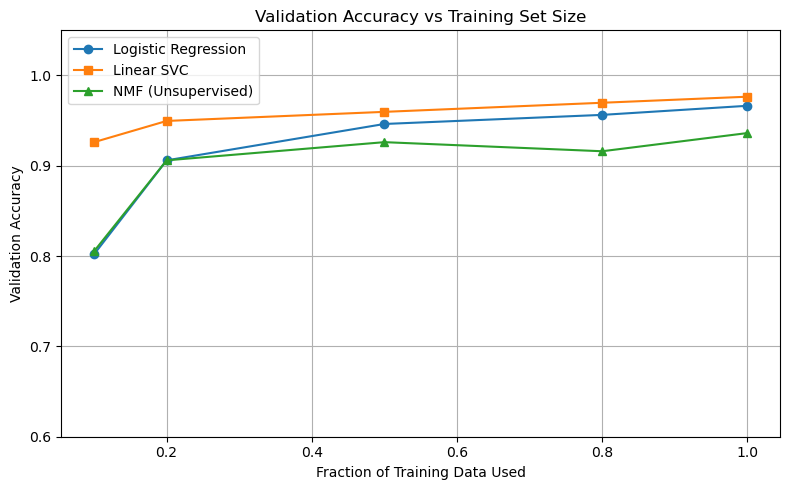

,Fraction,Logistic Regression Accuracy,Linear SVC Accuracy,NMF Accuracy
0,0.1,0.802013,0.926174,0.805369
1,0.2,0.906040,0.949664,0.906040
2,0.5,0.946309,0.959732,0.926174
3,0.8,0.956376,0.969799,0.916107
4,1.0,0.966443,0.976510,0.936242


In [23]:
# EVALUATE ACCURACY OF LOGISTIC REGRESSION, LINEAR SVC, AND NMF ON DIFFERENT FRACTIONS OF TRAINING DATA
#PLOTS PERFORMANCE

# TF-IDF matrix
X_full = tfidf_vectorizer.transform(train_df["CleanText"])
y_full = train_df["Category"]

# Training and testing split
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Results list
combined_results = []

# Fractions
fractions = [0.1, 0.2, 0.5, 0.8, 1.0]

for frac in fractions:
    n_samples = int(frac * X_train_full.shape[0])
    X_subset = X_train_full[:n_samples]
    y_subset = y_train_full[:n_samples]

    # Supervised - logistic regression
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_subset, y_subset)
    logreg_acc = accuracy_score(y_val, logreg.predict(X_val))

    # Supervised - linear SVC ---
    svc = LinearSVC(random_state=42)
    svc.fit(X_subset, y_subset)
    svc_acc = accuracy_score(y_val, svc.predict(X_val))

    # Unsupervised - NMF
    # Fit NMF on training subset
    nmf = NMF(n_components=15, init='nndsvda', max_iter=1000, random_state=42)
    W_subset = nmf.fit_transform(X_subset)

    # Assign topics to labels using majority vote from y_subset
    topic_assignments = np.argmax(W_subset, axis=1)
    topic_to_label = {}
    for topic in np.unique(topic_assignments):
        labels = y_subset.iloc[np.where(topic_assignments == topic)[0]]
        if not labels.empty:
            topic_to_label[topic] = labels.mode().iloc[0]

    # Transform validation set and predict using topic_to_label
    W_val = nmf.transform(X_val)
    val_topic_assignments = np.argmax(W_val, axis=1)
    val_preds = [topic_to_label.get(topic, "None") for topic in val_topic_assignments]
    nmf_acc = accuracy_score(y_val, val_preds)

    # Append results
    combined_results.append({
        "Fraction": frac,
        "Logistic Regression Accuracy": logreg_acc,
        "Linear SVC Accuracy": svc_acc,
        "NMF Accuracy": nmf_acc
    })

# Convert to dataframe 
combined_df = pd.DataFrame(combined_results)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(combined_df["Fraction"], combined_df["Logistic Regression Accuracy"], marker='o', label="Logistic Regression")
plt.plot(combined_df["Fraction"], combined_df["Linear SVC Accuracy"], marker='s', label="Linear SVC")
plt.plot(combined_df["Fraction"], combined_df["NMF Accuracy"], marker='^', label="NMF (Unsupervised)")
plt.title("Validation Accuracy vs Training Set Size")
plt.xlabel("Fraction of Training Data Used")
plt.ylabel("Validation Accuracy")
plt.ylim(0.6, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

combined_df